In [109]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(11,8)})
pd.set_option("display.max_columns",30)

#estymatory
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, roc_curve, auc, plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

### credit card default data

In [43]:
default = pd.read_excel(os.getcwd()+"//data//default-of-credit-card-clients.xls",
                       skiprows=1)\
.drop("ID",axis=1)\
.rename(columns={"default payment next month":"default"})

default["SEX"] = np.where(default["SEX"]==2,0,default["SEX"])
default["MARRIAGE"] = np.where(default["MARRIAGE"]==2,0,
                              np.where(default["MARRIAGE"]==3,2,default["MARRIAGE"]))

In [44]:
cols = ["SEX","EDUCATION","MARRIAGE"]
for col in cols:
        default[col] = pd.Categorical(default[col])

### last 6 months default count

In [45]:
last_def_count=default.iloc[:,range(5,11)]\
.reset_index()\
.melt(id_vars="index")\
.assign(value = lambda x: x["value"].apply(lambda y: 1 if y>0 else 0))\
.pivot(index="index",
      columns="variable")\
.reset_index(drop=True)\
.assign(last_def_count = lambda x: x[x.columns].sum(axis=1))["last_def_count"]

default.insert(11,"last_def_count",last_def_count)

### weighted payment history

In [46]:
def weighted_pmt_hist(df):
    return df["PAY_0"]+df["PAY_2"]/2+df["PAY_3"]/3+df["PAY_4"]/4+df["PAY_5"]/5+df["PAY_6"]/6
    
default["weighted_pmt_hist"] = default.apply(weighted_pmt_hist,axis=1)

### bill_amt and pay_amt mean ignoring zeroes

In [47]:
bill = ["BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6"]
pmt = ["PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"]

default["avg_bill_amt"] = default[default[bill]!=0][bill].mean(axis=1).fillna(0)
default["avg_pmt_amt"] = default[default[pmt]!=0][pmt].mean(axis=1).fillna(0)

### train test split

In [48]:
X = pd.get_dummies(default.drop("default",axis=1),drop_first=True)
y = default["default"]

In [49]:
X_train, X_test = train_test_split(X, train_size=3/4, random_state=123, stratify=y)
y_train, y_test = train_test_split(y, train_size=3/4, random_state=123, stratify=y)

## GLM

In [50]:
glm = LogisticRegression(penalty="none",
                        max_iter=10000)
scores = cross_validate(
    glm,
    X_train, 
    y_train, 
    cv=10,
    return_train_score=True,
    scoring="roc_auc"
)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.342080,0.002999,0.639122,0.652431
1,0.434177,0.003000,0.649082,0.650927
2,0.447165,0.003001,0.643007,0.651711
3,0.374085,0.001999,0.657868,0.649260
4,0.337077,0.003003,0.655330,0.647646
5,0.340080,0.003003,0.636362,0.651620
6,0.838196,0.003000,0.723266,0.702972
7,0.919214,0.002995,0.676781,0.710017
8,0.379085,0.003002,0.663906,0.648744
9,0.407090,0.002999,0.636034,0.652551


## wybór cech istotnych dla modelu

In [51]:
selector = RFECV(glm, 
                 step=1, 
                 min_features_to_select=1, 
                 cv=10, 
                 scoring="roc_auc")
selector.fit(X_train, y_train)

RFECV(cv=10, estimator=LogisticRegression(max_iter=10000, penalty='none'),
      scoring='roc_auc')

In [52]:
selected_features_df = pd.DataFrame({
    "selected": selector.support_,
    "ranking": selector.ranking_
}, index=X.columns)
selected_features_df

,selected,ranking
LIMIT_BAL,False,16
AGE,False,3
PAY_0,True,1
PAY_2,True,1
PAY_3,True,1
PAY_4,True,1
PAY_5,False,2
PAY_6,True,1
last_def_count,True,1
BILL_AMT1,False,11


In [53]:
ult_features = selected_features_df[selected_features_df["selected"]==True].index.to_list()
X_train = X_train[ult_features]
X_test = X_test[ult_features]

In [54]:
glm = LogisticRegression(penalty="none",
                        max_iter=10000)
scores = cross_validate(
    glm,
    X_train, 
    y_train, 
    cv=10,
    return_train_score=True,
    scoring="roc_auc"
)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.100024,0.003001,0.754266,0.740767
1,0.096024,0.001997,0.717724,0.744489
2,0.110024,0.002000,0.730979,0.743907
3,0.136032,0.003000,0.740292,0.742009
4,0.130030,0.003000,0.768346,0.739101
5,0.141032,0.003000,0.738490,0.742745
6,0.116027,0.004001,0.746424,0.741629
7,0.092013,0.002000,0.736121,0.742343
8,0.127029,0.002000,0.721434,0.743544
9,0.128032,0.002000,0.749253,0.740064


In [55]:
glm_prediction = pd.DataFrame(glm.fit(X_train,y_train).predict_proba(X_test),columns=["glm_pred_0","glm_pred_1"])

## knn classifier

In [56]:
pipeline_knn = Pipeline(steps=[
    ("std_scaler", StandardScaler()),
    ("classifier", GridSearchCV(KNeighborsClassifier(),
                                param_grid = {"n_neighbors":range(2,100,2)},
                                cv=5,
                                scoring="roc_auc",
                                verbose=1,
                                n_jobs=6,
                                refit=True))
])
knn = pipeline_knn.fit(X_train,y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


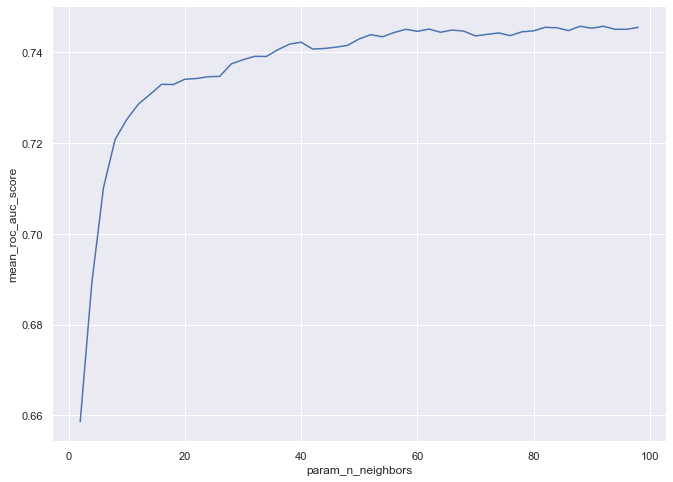

{'n_neighbors': 88}


0.7457638495709544

In [70]:
sns.lineplot(data=pd.DataFrame(knn.named_steps["classifier"].cv_results_),
            x = "param_n_neighbors",
            y = "mean_test_score")
plt.ylabel("mean_roc_auc_score")
plt.show()

print(knn.named_steps["classifier"].best_params_)
knn.named_steps["classifier"].best_score_

In [58]:
knn_prediction = pd.DataFrame(knn.predict_proba(X_test),columns=["knn_pred_0","knn_pred_1"])

### naive Bayes classifier

In [73]:
bayes = BernoulliNB()

scores = cross_validate(
    bayes,
    X_train, 
    y_train, 
    cv=10,
    return_train_score=True,
    scoring="roc_auc"
)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.012003,0.004000,0.757523,0.740513
1,0.009001,0.003009,0.728681,0.743945
2,0.009008,0.003013,0.735505,0.743134
3,0.009002,0.002994,0.743865,0.742195
4,0.008994,0.003008,0.771535,0.739489
5,0.009008,0.003013,0.739786,0.742680
6,0.010996,0.002001,0.741844,0.742403
7,0.009002,0.003008,0.730374,0.743721
8,0.008988,0.004023,0.729667,0.743956
9,0.009002,0.004008,0.744504,0.742216


In [78]:
bayes_prediction = pd.DataFrame(bayes.fit(X_train,y_train).predict_proba(X_test),
                                columns=["bayes_pred_0","bayes_pred_1"])

## ewaluacja modeli na zbiorze testowym cz.1 

In [97]:
pred_labels = pd.concat([pd.Series(glm.predict(X_test)),pd.Series(knn.predict(X_test)),pd.Series(bayes.predict(X_test))],axis=1)
pred_labels.columns = ["glm_pred_lab","knn_pred_lab","bayes_pred_lab"]
all_preds = pd.concat([pd.DataFrame(y_test).reset_index(drop=True),glm_prediction,knn_prediction,bayes_prediction,pred_labels],axis=1)

In [98]:
all_preds

,default,glm_pred_0,glm_pred_1,knn_pred_0,knn_pred_1,bayes_pred_0,bayes_pred_1,glm_pred_lab,knn_pred_lab,bayes_pred_lab
0,1,0.761869,0.238131,0.818182,0.181818,0.096532,0.903468,0,0,1
1,1,0.870466,0.129534,0.863636,0.136364,0.985445,0.014555,0,0,0
2,0,0.638883,0.361117,0.579545,0.420455,0.046644,0.953356,0,0,1
3,0,0.881165,0.118835,0.806818,0.193182,0.990489,0.009511,0,0,0
4,0,0.895672,0.104328,0.909091,0.090909,0.992168,0.007832,0,0,0
...,...,...,...,...,...,...,...,...,...,...
7495,0,0.877665,0.122335,0.909091,0.090909,0.990489,0.009511,0,0,0
7496,0,0.884579,0.115421,0.829545,0.170455,0.990489,0.009511,0,0,0
7497,1,0.566061,0.433939,0.556818,0.443182,0.056414,0.943586,0,0,1
7498,1,0.490674,0.509326,0.443182,0.556818,0.010263,0.989737,1,1,1


In [113]:
print("roc auc score GLM: ",roc_auc_score(all_preds["default"],all_preds["glm_pred_1"]))
print("roc auc KNN: ",roc_auc_score(all_preds["default"],all_preds["knn_pred_1"]))
print("roc auc naive Bayes: ",roc_auc_score(all_preds["default"],all_preds["bayes_pred_1"]))

roc auc score GLM:  0.7343498635066968
roc auc KNN:  0.7464584649738051
roc auc naive Bayes:  0.7381361040447074


In [125]:
glm_fpr, glm_tpr, thresholds = roc_curve(all_preds["default"],all_preds["glm_pred_1"])
knn_fpr, knn_tpr, thresholds = roc_curve(all_preds["default"],all_preds["knn_pred_1"])
bayes_fpr, bayes_tpr, thresholds = roc_curve(all_preds["default"],all_preds["bayes_pred_1"])

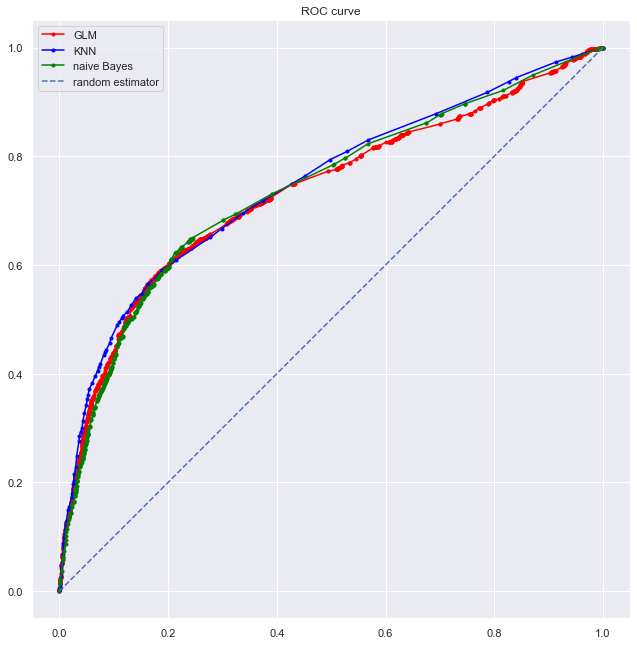

In [140]:
plt.plot(glm_fpr,glm_tpr, color="red", label="GLM", marker=".")
plt.plot(knn_fpr,knn_tpr, color="blue",label="KNN",marker=".")
plt.plot(bayes_fpr,bayes_tpr, color="green",label="naive Bayes",marker=".")
plt.plot(np.linspace(0,1,50),np.linspace(0,1,50),linestyle="--",label="random estimator")
plt.legend()
plt.title("ROC curve")
plt.gca().set_aspect('equal')
plt.show()